# Distribution State Estimation - Example

Initial idea is to build  a model(s) that utilise available information, including power system and weather data, to predict distribution network state at particular points of interest. 

The inital model and results outlined in this notebook describes the use of real and reactive power flows and weather data "recorded" at a primary substation to predict voltages on LV feeders further downstream that have significant PV connections. The data used throughout this case study has been simulated using openDSS models of LVNS networks alongside the Sandia Labs PV tool kit.

The simulated data is used to develope a Vine Copula model that captures dependencies between each of the variables. The Vine Copula model is then used for conditional sampling i.e. --> using the primary substation data and the developed model, predict voltages at the unmonitored LV feeders 

While the use case outlined here may change, the main purpose at this stage is to highlight the Vine Copula model development and application. The Vine Copula toolboxes are implemented in R, although I am using Python to drive them.

A summary of this use case is provided in the following diagram:

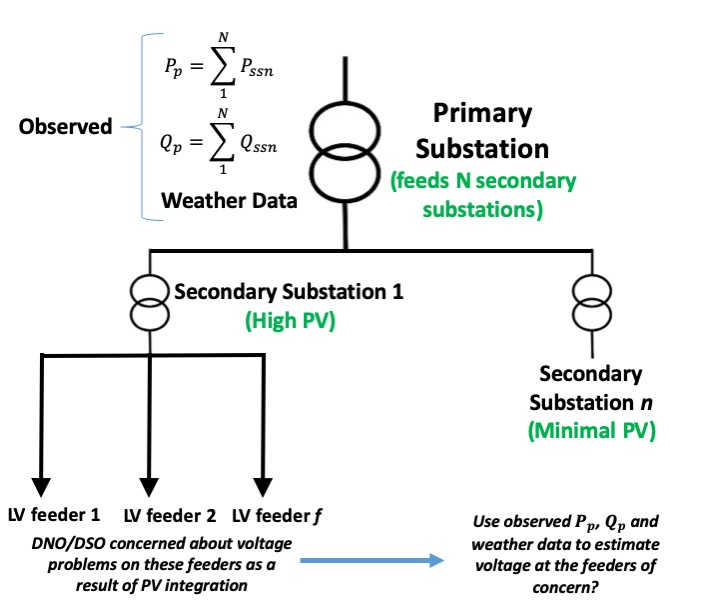

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(filename = "state_estimation.jpg")

# Method

Import all dependencies. This includes the rpy2 python package which allows R libraries to be used within Python.

In [2]:
import os
import opendssdirect as dss
import pandas as pd
import datetime
import numpy as np
import seaborn as sb
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from interpolateLatLon import interpolateLatLon
from scipy.interpolate import griddata
from scipy.interpolate import interp1d
import pvlib
from pvPowerOut import pvPowerOut
import random
from run_dss import run_dss
import seaborn as sns
from scipy import stats
from ecdf import ecdf
from ecdf import probability_integral_transform
import warnings
warnings.filterwarnings("ignore")
import math
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import r, pandas2ri
from rpy2.robjects.conversion import localconverter
r('.libPaths("//Users//rory//anaconda//envs//py37//lib//R//library")')
VineCopula = importr('VineCopula')
VineConditional = importr('CDVineCopulaConditional')

In [3]:
def uni_transform(rawData, obs):
    x, y = ecdf(rawData, obs)
    u = probability_integral_transform(rawData)
    return u, x, y

Simulate Secondary Substation 1 data - this substation has four separate LV feeders and varying levels of (high) PV connections and therefore may incur overvoltages at time of high embedded generation output. 

In [4]:
pvPer1 = 90
pvPer2 = 20
pvPer3 = 10
pvPer4 = 40
pvRat = 12000
lat = 56.339 
lon = - 2.809
leap = 0

network = 1
feeder = 1
n1, f1p1, f1p2, f1p3, v11, p11, q11, nodeV, weather, id1 = run_dss(network, feeder, pvPer1, pvRat, lat, lon, 0, leap, 1)

feeder = 2
n2, f2p1, f2p2, f2p3, v12, p12, q12, nodeV, weather, id2 = run_dss(network, feeder, pvPer2, pvRat, lat, lon, 0, leap, 1)

feeder = 3
n3, f3p1, f3p2, f3p3, v13, p13, q13, nodeV, weather, id3 = run_dss(network, feeder, pvPer3, pvRat, lat, lon, 0, leap, 1)

feeder = 4
n4, f4p1, f4p2, f4p3, v14, p14, q14, nodeV, weather, id4 = run_dss(network, feeder, pvPer4, pvRat, lat, lon, 0, leap, 1)


Simulate Secondary Substation 2 data - this substation has five LV feeders and zero PV connections.

In [5]:
network = 2
feeder = 1
n1, f1p1, f1p2, f1p3, v21, p21, q21, nodeV, weather, id1 = run_dss(network, feeder, 0, 0, lat, lon, 0, leap, 1)

feeder = 2
n1, f1p1, f1p2, f1p3, v22, p22, q22, nodeV, weather, id1 = run_dss(network, feeder, 0, 0, lat, lon, 0, leap, 1)

feeder = 3
n1, f1p1, f1p2, f1p3, v23, p23, q23, nodeV, weather, id1 = run_dss(network, feeder, 0, 0, lat, lon, 0, leap, 1)

feeder = 4
n1, f1p1, f1p2, f1p4, v24, p24, q24, nodeV, weather, id1 = run_dss(network, feeder, 0, 0, lat, lon, 0, leap, 1)

feeder = 5
n1, f1p1, f1p2, f1p5, v25, p25, q25, nodeV, weather, id1 = run_dss(network, feeder, 0, 0, lat, lon, 0, leap, 1)

Compile Secondary Substation 1 and 2 data to synthesise primary substation real and reactive power flows. 

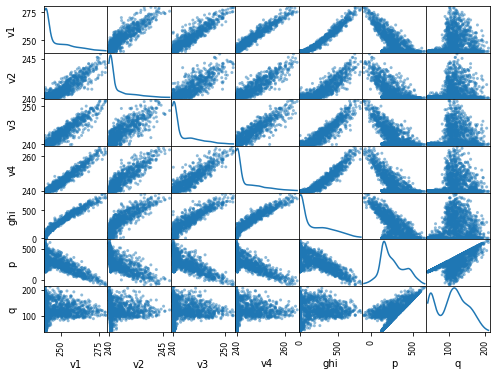

In [6]:
powerSum = np.sum((p11, p12, p13, p14, p21, p22, p23, p24, p25), axis=0)
reactiveSum = np.sum((q11, q12, q13, q14, q21, q22, q23, q24, q25), axis=0)

v = np.concatenate((v11, v12, v13, v14), axis = 1)

wet = np.zeros([1728,1])
wet[0:,0] = weather['GHI'].to_numpy()
networkPVProxy = np.concatenate((v,
                        wet,
                        powerSum,
                        reactiveSum), axis=1) 



label=list()
for i in range(1, (v.shape[1]+1)):
               label.append('v' + str(i))
               
label.append('ghi')
label.append('p')
label.append('q') 
              
networkPV = pd.DataFrame (networkPVProxy, 
                            columns = label)



pd.plotting.scatter_matrix(networkPV, alpha=0.5, figsize=(8,6), diagonal='kde');


Analysis of the above highlights relation between LV feeder voltages at secondary substation 1 and the synthesised primary substation p, q and global horizontal irradiance (ghi). Main observations:

-> Strong dependence and positive correlation between the voltages. 

-> Negative correlations between real power and voltages. 

Despite these dependencies, this example assumes none of the voltages will be observed in real/operational time. Though it does assume they are monitored at some point to gather training data. Something to think about.


Transform raw data into Copula Space (uniform marginals) using the empirical cumulative distributions for input to Copula models.

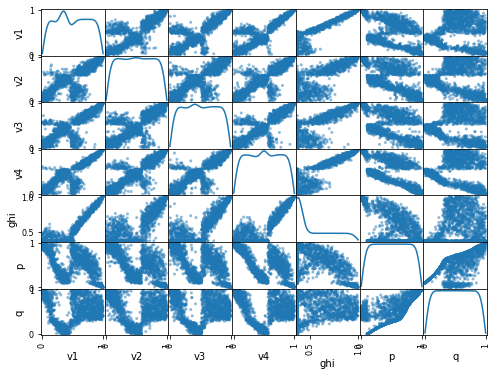

In [7]:
U = np.zeros([networkPV.shape[0], networkPV.shape[1]])
X = np.zeros([networkPV.shape[0], networkPV.shape[1]])
Y = np.zeros([networkPV.shape[0], networkPV.shape[1]])

for i in range(0, networkPV.shape[1]):
     rawData = np.zeros([networkPV.shape[0],1])
     rawData[0:,0] = networkPV[label[i]].to_numpy()
     obs = networkPV.shape[0]
     u, x, y = uni_transform(rawData, obs)
     U[0:,i] = u[0:,0]
     X[0:,i] = x[0:,0]
     for j in range(0, networkPV.shape[0]):
         Y[j,i] = y[j]

uniformNetworkPV = pd.DataFrame(U, columns=label)
pd.plotting.scatter_matrix(uniformNetworkPV, 
                           alpha=0.5, figsize=(8,6), diagonal='kde');

Split simulated dataset into a train and test set - 80% of the data is used to train the Copula model while the remaining 20% is held out for testing. Also, extract the actual data (i.e the raw datset) for the corresponding test period so comparisons can be undertaken between predicted and actual values 

In [8]:
days = (uniformNetworkPV.shape[0]/48)
trainDays = round(days*0.8)
testDays = days - trainDays

set1 = uniformNetworkPV.iloc[0:(48*trainDays), 0:]
set2 = uniformNetworkPV.iloc[(48*trainDays):uniformNetworkPV.shape[0], 0:]

act2 = networkPV.iloc[(48*trainDays):uniformNetworkPV.shape[0], 0:]

with localconverter(robjects.default_converter + pandas2ri.converter):
  trainData = robjects.conversion.py2rpy(set1)
  
with localconverter(robjects.default_converter + pandas2ri.converter):
  testData = robjects.conversion.py2rpy(set2)

Within this example there are three conditoning variables (p, q, and ghi) and four repsonse variables (the four LV feeder voltages at Secondary Substation 1). Use these variables plus the training data to define the C and D vine matrices. In this example we are using the first D Vine structure. This model selection requires further investigation to determine the "optimal" Vine structure.

In [9]:
nCond = 3
nResp = 4

ListVines = VineConditional.CDVineCondListMatrices(trainData,Nx=nCond)

CVine=ListVines.rx2("CVine")
DVine=ListVines.rx2("DVine")

print(DVine[0])

     [,1] [,2] [,3] [,4] [,5] [,6] [,7]
[1,]    5    0    0    0    0    0    0
[2,]    4    6    0    0    0    0    0
[3,]    3    4    7    0    0    0    0
[4,]    2    3    4    1    0    0    0
[5,]    1    2    3    4    2    0    0
[6,]    7    1    2    3    4    3    0
[7,]    6    7    1    2    3    4    4



Use the define DVine structure to train the Vine model. The family set is the different bivariate copulas that can be selected throughout training.

In [10]:
fam = list([0,1,2,3,4,6,7,8,9,10,13,14,16, 17, 18, 19, 20, 23, 
            24, 26, 27, 28, 29, 30, 33, 34, 36, 37, 38, 39, 40, 
            104, 114, 124, 134, 204, 214, 224, 234])

familyset = robjects.IntVector(fam)

RVM = VineConditional.CDVineCondFit(trainData, Nx=nCond, Matrix=DVine[0],familyset=familyset)
print(RVM)

D-vine copula with the following pair-copulas:
Tree 1:
6,5  Rotated Tawn type 2 90 degrees (par = -2.2, par2 = 0.39, tau = -0.27) 
7,6  Tawn  type 1 (par = 11.18, par2 = 0.6, tau = 0.56) 
1,7  Tawn  type 2 (par = 1.55, par2 = 0.17, tau = 0.1) 
2,1  BB8 (par = 4.7, par2 = 0.97, tau = 0.64) 
3,2  BB8 (par = 4.89, par2 = 0.93, tau = 0.62) 
4,3  BB8 (par = 6, par2 = 0.95, tau = 0.7) 

Tree 2:
7,5;6  BB8 (par = 6, par2 = 0.85, tau = 0.63) 
1,6;7  Rotated BB8 270 degrees (par = -5.52, par2 = -0.99, tau = -0.7) 
2,7;1  Rotated BB8 90 degrees (par = -4.66, par2 = -0.51, tau = -0.29) 
3,1;2  Tawn  type 2 (par = 2.29, par2 = 0.61, tau = 0.39) 
4,2;3  t (par = 0.63, par2 = 4.31, tau = 0.44) 

Tree 3:
1,5;7,6  Tawn  type 2 (par = 2.13, par2 = 0.51, tau = 0.33) 
2,6;1,7  Rotated Gumbel 90 degrees (par = -1.05, tau = -0.05) 
3,7;2,1  Rotated Tawn type 1 90 degrees (par = -1.45, par2 = 0.2, tau = -0.11) 
4,1;3,2  Tawn  type 2 (par = 1.71, par2 = 0.49, tau = 0.26) 

Tree 4:
2,5;1,7,6  Rotated BB8 270 

Parameters of the trained model are summarised above.

Extract the conditioning variables from the test dataset and use these, plus the Vine copula model (RVM), to predict the four voltages. This example follows a Monte Carlo based approach, where each voltage is sampled 100 times from the model. 

The following figure highlights the modelled voltages in comparison to the actual values. These include the means of the 100 samples as well the 5 - 95 percentile ranges.

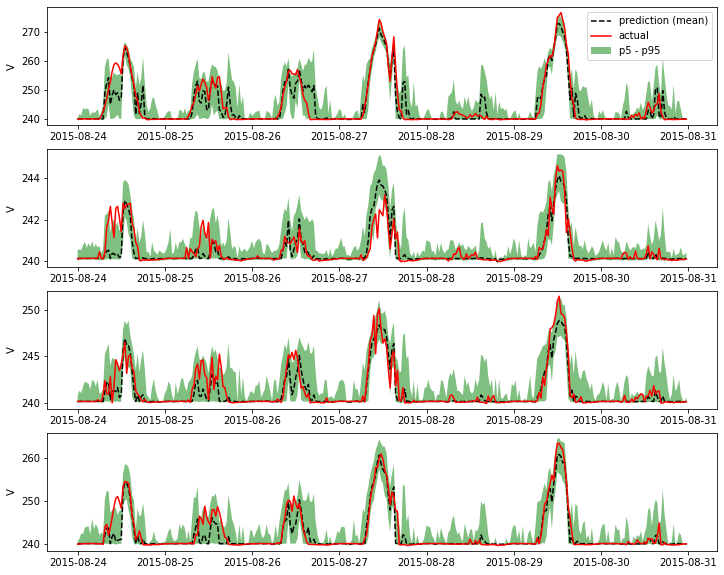

In [12]:
dfCond = set2.iloc[0:, nResp:(nCond+nResp)]
with localconverter(robjects.default_converter + pandas2ri.converter):
  condition = robjects.conversion.py2rpy(dfCond)

fig, axs = plt.subplots(nResp, figsize=(12,10))


predictionsAll = np.zeros([set2.shape[0], nResp])

for var in range(0, nResp):
    mat = np.zeros([set2.shape[0],100])
    actual = act2
    
    for i in range(0,100):
        
        Sim = VineConditional.CDVineCondSim(RVM,condition)
        
        mat[0:,i] = np.array(Sim)[0:,var]
    
    
    mean = np.mean(mat, axis=1)
    up5 = np.percentile(mat, 5, axis = 1)
    up95 = np.percentile(mat, 95, axis = 1)
    
    uu = U[0:, var]
    xx = X[0:, var]
    yy = Y[0:, var]
    
    predMean = np.zeros([mat.shape[0],1])
    pred5 = np.zeros([mat.shape[0],1])
    pred95 = np.zeros([mat.shape[0],1])
    
    for i in range(0, mat.shape[0]):
        diff = mean[i] - yy
        predMean[i,0] = xx[np.argmin(abs(diff))]
        diff = up5[i] - yy
        pred5[i,0] = xx[np.argmin(abs(diff))]
        diff = up95[i] - yy
        pred95[i,0] = xx[np.argmin(abs(diff))]
    
    
    
    
    axs[var].fill_between(weather.iloc[(48*trainDays):uniformNetworkPV.shape[0], 0:].index, pred5[0:,0], pred95[0:,0], alpha=0.5, facecolor='green', label = 'p5 - p95')
    axs[var].plot_date(weather.iloc[(48*trainDays):uniformNetworkPV.shape[0], 0:].index, predMean, 'k--', label = 'prediction (mean)')
    axs[var].plot_date(weather.iloc[(48*trainDays):uniformNetworkPV.shape[0], 0:].index, (actual.iloc[0:,var].to_numpy()),'r', label='actual')
    
    predictionsAll[0:,var] = predMean[:,0]
    
    axs[var].set_ylabel('V')

axs[0].legend();

Some analysis of the errors between the predicted (i.e. the mean of the Vine Copula conditional smaples) and actual voltage values on each feeder. Firstly, MAPEs and MAEs across the full test period:

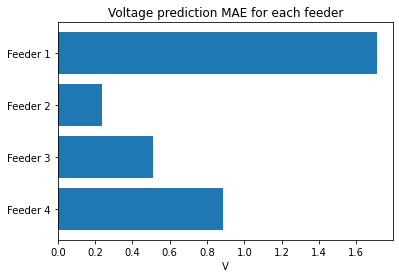

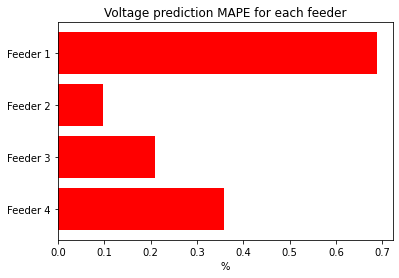

In [14]:
actNP = (actual.iloc[0:,0:nResp].to_numpy())

errsA = abs(predictionsAll - actNP)

errsP = abs((errsA/actNP)*100)

mae = np.mean(errsA, axis=0)

mape = np.mean(errsP, axis=0)

feeders = ('Feeder 1', 'Feeder 2', 'Feeder 3', 'Feeder 4')
y_pos = np.arange(len(feeders))
fig, ax = plt.subplots()
ax.barh(y_pos, mae, align = 'center')
ax.set_yticks(y_pos)
ax.set_yticklabels(feeders)
ax.set_xlabel('V')
ax.invert_yaxis() 
ax.set_title('Voltage prediction MAE for each feeder')

fig, ax = plt.subplots()
ax.barh(y_pos, mape, align = 'center', color='r')
ax.set_yticks(y_pos)
ax.set_yticklabels(feeders)
ax.set_xlabel('%')
ax.invert_yaxis() 
ax.set_title('Voltage prediction MAPE for each feeder');

Errors are low - Feeder 1 worst performing (this feeder was modelled with 90% of customers having PV installed). The errors may be low because they are including times where it is "easier" to predict voltage as it is relatively stable i.e. late night/early morning.

Lets look at MAE and MAPEs for each half hourly yime interval as well:

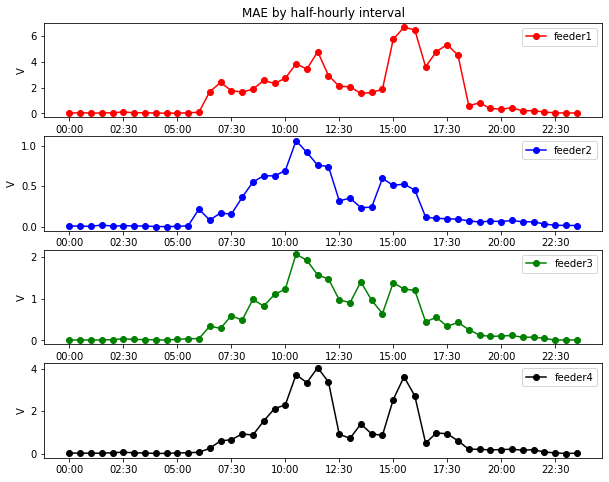

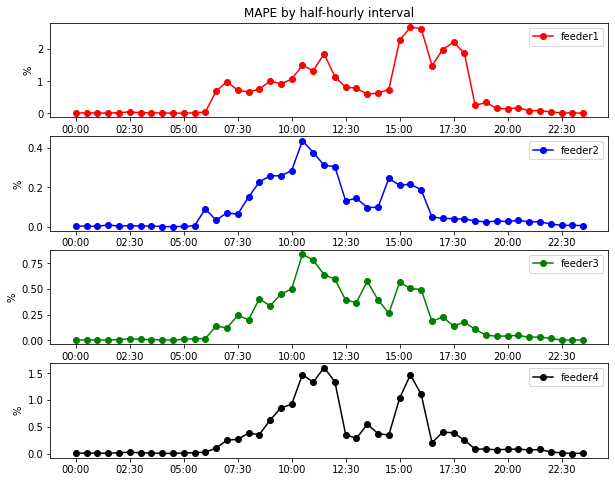

In [16]:
eA = pd.DataFrame(errsA, index = weather.iloc[(48*trainDays):uniformNetworkPV.shape[0], 0:].index)

ids=weather.iloc[0:48, 0:].index
match_timestamp = list(ids.strftime("%H:%M"))

timeErrors = np.zeros([48, nResp])
for i in range(0, len(match_timestamp)):
    timeErrors[i,0:nResp] = np.mean(eA.loc[eA.index.strftime("%H:%M") == match_timestamp[i]].to_numpy(), axis=0)

from matplotlib.ticker import MaxNLocator
fig, axs = plt.subplots(nResp, figsize =(10,8))
colors = ['r', 'b', 'g', 'k']

for i in range(0, nResp):
    axs[i].plot_date(ids.strftime("%H:%M"), timeErrors[0:,i], label = ('feeder' + str(i+1)), color = colors[i], linestyle='solid')
    axs[i].set_ylabel('V')
    axs[i].xaxis.set_major_locator(MaxNLocator(nbins=12))
    axs[i].legend()

axs[0].set_title('MAE by half-hourly interval')


eP = pd.DataFrame(errsP, index = weather.iloc[(48*trainDays):uniformNetworkPV.shape[0], 0:].index)

timeErrorsP = np.zeros([48, nResp])
for i in range(0, len(match_timestamp)):
    timeErrorsP[i,0:nResp] = np.mean(eP.loc[eP.index.strftime("%H:%M") == match_timestamp[i]].to_numpy(), axis=0)

fig, axs = plt.subplots(nResp, figsize =(10,8))

for i in range(0, nResp):
    axs[i].plot_date(ids.strftime("%H:%M"), timeErrorsP[0:,i], label = ('feeder' + str(i+1)), color = colors[i], linestyle='solid')
    axs[i].set_ylabel('%')
    axs[i].xaxis.set_major_locator(MaxNLocator(nbins=12))
    axs[i].legend()

axs[0].set_title('MAPE by half-hourly interval');

Errors increase during the day and fall back in the evening/early morning. Although we are still getting some decent  predictions. We are also of course assuming here we have decent amounts of training data...